### CricShot10 Video Classification

(Use this with permission)

- `Source` - https://drive.google.com/drive/folders/1DPHURwQk5R8blgjM8VNz6Q68LqckxljX?usp=drive_link

Notebook to set the baseline model


In [74]:
# Loading Dependencies
from pathlib import Path
from typing import Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader

# Contains helper functions to parse the dataset
import utils

# Contains the configuration file

In [9]:
# Global File Paths
# Change them before running the notebook
# These all are specific to my system
ZIP_FILES_PATH = "zipped-data"
DATASET_NAME = "CricShot10"
DATASET_ROOT_PATH = Path("CricShot10/")
TO_DIR = "dataset"

In [10]:
# 80% of videos are used for training the model
TRAIN_SET_RATIO = 0.8
TEST_SET_RATIO = 1 - TRAIN_SET_RATIO

In [11]:
# Majority of videos are 25FPS with a few being 30FPS
# Uniformly Sampling 10 frames from each videos
N_FRAMES = 10
# Change each frame (which is basically a picture) to (height, width) - (224, 224)
FRAME_SHAPE = (224, 224)
# Each batch contains 16 videos
BATCH_SIZE = 16

In [12]:
# Extracting all files
# Only needs to run once if the data is zipped
if not DATASET_ROOT_PATH.exists() and not DATASET_ROOT_PATH.is_dir():
    utils.unzip_files(ZIP_FILES_PATH, DATASET_NAME)

Creating directory: CricShot10
Unzipping all the files: 
Unzipping: straight-20250524T095750Z-1-001.zip
Unzipping: sweep-20250524T095750Z-1-001.zip
Unzipping: square_cut-20250524T095750Z-1-001.zip
Unzipping: late_cut-20250524T095754Z-1-001.zip
Unzipping: pull-20250524T095751Z-1-001.zip
Unzipping: defense-20250524T102524Z-1-001.zip
Unzipping: cover-20250524T102526Z-1-001.zip
Unzipping: lofted-20250524T095752Z-1-001.zip
Unzipping: hook-20250524T095755Z-1-001.zip
Unzipping: flick-20250524T095756Z-1-001.zip
All files unzipped to: `/home/vaibhavrastogi/Documents/python/video-classfication/CricShot10`


In [14]:
# Our dataset does not uniform distribution of data in each of the 10 classes
# Waisting the only the minimum amount of videos
samples_per_class = min(
    (
        len(list(path.glob("*.avi")))
        for path in Path(DATASET_ROOT_PATH).iterdir()
        if path.is_dir()
    )
)
print("Minimum Number of samples per class taken:", samples_per_class)

Minimum Number of samples per class taken: 179


In [15]:
# Setup the directory structure with defined train and test directories
# Only needs to run once to setup the dataset directory
utils.setup_dataset_structure(
    from_dir=DATASET_ROOT_PATH,
    to_dir=TO_DIR,
    train_ratio=TRAIN_SET_RATIO,
    samples_per_class=samples_per_class,
)

Found dataset at: CricShot10
LOG: Creating directory 'dataset'
LOG: Creating directory 'dataset/train'
LOG: Creating directory 'dataset/test'


In [16]:
# Define train and test directories
root_dir = Path(TO_DIR)
train_dir = root_dir / "train"
test_dir = root_dir / "test"

In [17]:
train_paths = list(train_dir.glob("*/*.avi"))
test_paths = list(test_dir.glob("*/*.avi"))
print("No. of video files in training set:", len(train_paths))
print("No. of video files in testing set:", len(test_paths))

No. of video files in training set: 1430
No. of video files in testing set: 360


In [18]:
# Get all the classes in the dataset
class_names, classes_to_idx = utils.get_classes(train_dir)
idx_to_classes = {idx: class_name for class_name, idx in classes_to_idx.items()}
print("All Classes in dataset:", class_names)

All Classes in dataset: ['cover', 'defense', 'flick', 'hook', 'late_cut', 'lofted', 'pull', 'square_cut', 'straight', 'sweep']


In [19]:
class CricShot10(torch.utils.data.Dataset):
    def __init__(
        self,
        target_dir: str,
        transform=None,
        n_frames: int = 16,
        target_size: Tuple[int, int] = (224, 224),
    ):
        self.target_dir = target_dir
        self.paths = list(target_dir.glob("*/*.avi"))

        self.transform = transform
        self.n_frames = n_frames
        self.target_size = target_size
        self.class_names, self.class_to_idx = utils.get_classes(target_dir)

    def __len__(self):
        return len(self.paths)

    def load_video(self, idx: int) -> torch.Tensor:
        video_path = str(self.paths[idx])

        cap = cv2.VideoCapture(video_path)

        frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)

        indices = np.linspace(0, frame_count - 1, self.n_frames, dtype="int")

        frames = []
        for idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()

            if not ret:
                last_frame = (
                    frames[-1]
                    if frames
                    else np.zeros(
                        (self.target_size[0], self.target_size[1], 3), dtype=np.uint8
                    )
                )
                frames.append(last_frame)
                continue

            frame = cv2.resize(frame, self.target_size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        cap.release()

        if len(frames) < self.n_frames:
            # Pad with copies of the last frame
            last_frame = (
                frames[-1]
                if frames
                else np.zeros(
                    (self.target_size[0], self.target_size[1], 3), dtype=np.uint8
                )
            )
            frames.extend([last_frame] * (self.n_frames - len(frames)))

        # Pytorch requires (C, D, H, W)
        frames = np.transpose(np.array(frames), (3, 0, 2, 1))
        return frames

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        video = self.load_video(idx)
        class_name = "_".join(self.paths[idx].name.split("_")[:-1])
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(video), class_idx
        return video, class_idx

In [20]:
# TODO: add data augmentation

In [28]:
# shape: (C, D, H, W) as pytorch so requires
# shape: (3, 10, 224, 224)
train_dataset = CricShot10(
    train_dir,
    n_frames=N_FRAMES,
    target_size=FRAME_SHAPE,
)

test_dataset = CricShot10(
    test_dir,
    n_frames=N_FRAMES,
    target_size=FRAME_SHAPE,
)

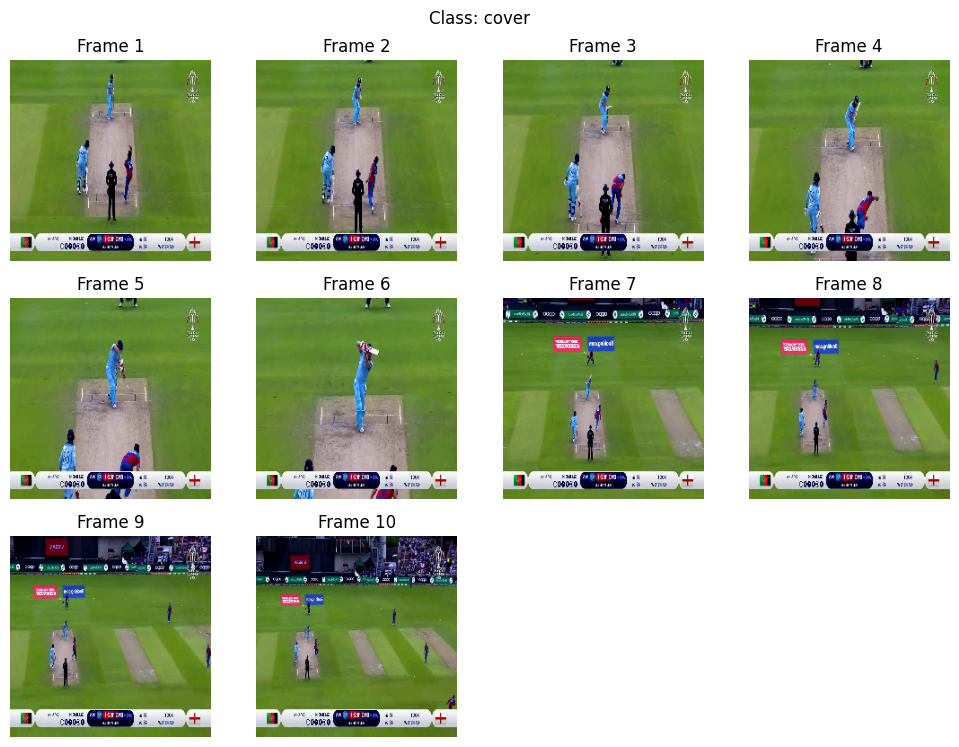

In [43]:
video, class_idx = train_dataset[0]
video = video.transpose((1, 3, 2, 0))  # tranpose so that matplotlib accepts the data
figure = plt.figure(figsize=(10, 10))
nrows, ncols = 4, 4
for idx in range(1, len(video) + 1):
    figure.add_subplot(nrows, ncols, idx)
    plt.title(f"Frame {idx}")
    plt.imshow(video[idx - 1])
    plt.axis(False)
plt.suptitle(f"Class: {idx_to_classes[class_idx]}")
plt.tight_layout()

In [49]:
# Create Dataloaders
# Shape: [16, 3, 10, 224, 224] as [batch_size, C, D, H, W]
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

In [76]:
# class Conv2Plus1D(nn.Module):
#     def __init__(
#         self,
#         in_channels: int = 3,
#         out_channels: int = 16,
#         kernel_size: Tuple[int, int, int] = (3, 7, 7),
#         # padding
#     ):
#         super().__init__()
#         self.block = nn.Sequential(
#             # Spatial decomposition
#             nn.Conv3d(
#                 in_channels=in_channels,
#                 out_channels=out_channels,
#                 kernel_size=(1, kernel_size[1], kernel_size[2]),
#                 padding="same",
#             ),
#             # Temporal decomposition
#             nn.Conv3d(
#                 in_channels=out_channels,
#                 out_channels=out_channels,
#                 kernel_size=(kernel_size[0], 1, 1),
#                 padding="same",
#             ),
#         )

#     def forward(self, x):
#         return self.block(x)


# class ResidualMain(nn.Module):
#     def __init__(
#         self,
#         in_channels: int = 3,
#         out_channels: int = 16,
#         kernel_size: Tuple[int, int, int] = (3, 7, 7),
#     ):
#         super().__init__()
#         self.block = nn.Sequential(
#             Conv2Plus1D(
#                 in_channels=in_channels,
#                 out_channels=out_channels,
#                 kernel_size=kernel_size,
#                 padding="same",
#             ),
#             nn.LayerNorm(),
#             nn.ReLU(),
#             Conv2Plus1D(
#                 in_channels=in_channels,
#                 out_channels=out_channels,
#                 kernel_size=kernel_size,
#                 padding="same",
#             ),
#             nn.LayerNorm(),
#         )

#     def forward(self, x):
#         return self.block(x)


# class Project(nn.Module):
#     def __init__(self, in_features: int, out_features: int):
#         super.__init__()
#         self.block = nn.Sequential(
#             nn.Linear(in_features=in_features, out_features=out_features),
#             nn.LayerNorm(),
#         )

#     def forward(self, x):
#         return self.block(x)

In [59]:
# class Model(nn.Module):
#     def __init__(
#         self, in_channels: int = 3, kernel_size: Tuple[int, int, int] = (3, 7, 7)
#     ):
#         super.__init__()

In [60]:
x = torch.randn(1, 3, 10, 224, 224)

In [62]:
m = Conv2Plus1D()

In [56]:
x.shape

torch.Size([1, 3, 10, 224, 224])

In [64]:
m(x).shape

torch.Size([1, 16, 10, 224, 224])

In [66]:
class Conv2Plus1D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Tuple[int, int, int] = (3, 7, 7),
        padding: str = "same",
    ):
        """
        A sequence of convolutional layers that first apply the convolution operation over the
        spatial dimensions, and then the temporal dimension.
        """
        super().__init__()

        # Convert padding string to appropriate padding values
        if padding == "same":
            spatial_pad = (kernel_size[1] // 2, kernel_size[2] // 2)
            temporal_pad = kernel_size[0] // 2
        else:
            spatial_pad = (0, 0)
            temporal_pad = 0

        self.seq = nn.Sequential(
            # Spatial decomposition: (1, H, W) kernel
            nn.Conv3d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=(1, kernel_size[1], kernel_size[2]),
                padding=(0, spatial_pad[0], spatial_pad[1]),
            ),
            # Temporal decomposition: (T, 1, 1) kernel
            nn.Conv3d(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=(kernel_size[0], 1, 1),
                padding=(temporal_pad, 0, 0),
            ),
        )

    def forward(self, x):
        return self.seq(x)


class ResidualMain(nn.Module):
    """
    Residual block of the model with convolution, layer normalization, and ReLU.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Tuple[int, int, int] = (3, 3, 3),
    ):
        super().__init__()
        self.seq = nn.Sequential(
            Conv2Plus1D(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                padding="same",
            ),
            nn.GroupNorm(1, out_channels),  # Equivalent to LayerNorm for conv layers
            nn.ReLU(),
            Conv2Plus1D(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                padding="same",
            ),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        return self.seq(x)


class ResizeVideo(nn.Module):
    """
    Resizes video by downsampling spatial dimensions by factor of 2.
    """

    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

    def forward(self, x):
        return self.pool(x)


class Project(nn.Module):
    """
    Projects input features to output features using linear transformation.
    """

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.norm = nn.GroupNorm(1, out_features)

    def forward(self, x):
        # Reshape for linear layer: (B, C, D, H, W) -> (B, D, H, W, C)
        B, C, D, H, W = x.shape
        x = x.permute(0, 2, 3, 4, 1)  # (B, D, H, W, C)
        x = self.linear(x)  # (B, D, H, W, out_features)
        x = x.permute(0, 4, 1, 2, 3)  # (B, out_features, D, H, W)
        x = self.norm(x)
        return x


class VideoClassificationModel(nn.Module):
    """
    Complete video classification model based on the provided architecture.
    """

    def __init__(self, num_classes: int = 10):
        super().__init__()

        # Initial Conv2Plus1D layer
        self.initial_conv = Conv2Plus1D(
            in_channels=3, out_channels=16, kernel_size=(3, 7, 7)
        )

        # Batch normalization and activation
        self.initial_norm = nn.GroupNorm(1, 16)
        self.initial_relu = nn.ReLU()

        # First resize (224x224 -> 112x112)
        self.resize1 = ResizeVideo()

        # First residual block
        self.residual1 = ResidualMain(16, 16, (3, 3, 3))

        # Second resize (112x112 -> 56x56)
        self.resize2 = ResizeVideo()

        # First projection layer (16 -> 32 channels)
        self.project1 = Project(16, 32)

        # Second residual block
        self.residual2 = ResidualMain(32, 32, (3, 3, 3))

        # Third resize (56x56 -> 28x28)
        self.resize3 = ResizeVideo()

        # Second projection layer (32 -> 64 channels)
        self.project2 = Project(32, 64)

        # Third residual block
        self.residual3 = ResidualMain(64, 64, (3, 3, 3))

        # Fourth resize (28x28 -> 14x14)
        self.resize4 = ResizeVideo()

        # Third projection layer (64 -> 128 channels)
        self.project3 = Project(64, 128)

        # Fourth residual block
        self.residual4 = ResidualMain(128, 128, (3, 3, 3))

        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool3d((1, 1, 1))

        # Flatten
        self.flatten = nn.Flatten()

        # Final dense layer
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        # Input shape: (batch, 3, 10, 224, 224)

        # Initial convolution
        x = self.initial_conv(x)  # (batch, 16, 10, 224, 224)
        x = self.initial_norm(x)
        x = self.initial_relu(x)

        # First downsampling and residual
        x = self.resize1(x)  # (batch, 16, 10, 112, 112)
        residual_out1 = self.residual1(x)  # (batch, 16, 10, 112, 112)
        x = x + residual_out1  # Skip connection

        # Second downsampling
        x = self.resize2(x)  # (batch, 16, 10, 56, 56)

        # Project and residual
        x_projected1 = self.project1(x)  # (batch, 32, 10, 56, 56)
        residual_out2 = self.residual2(x_projected1)  # (batch, 32, 10, 56, 56)
        x = x_projected1 + residual_out2  # Skip connection

        # Third downsampling
        x = self.resize3(x)  # (batch, 32, 10, 28, 28)

        # Project and residual
        x_projected2 = self.project2(x)  # (batch, 64, 10, 28, 28)
        residual_out3 = self.residual3(x_projected2)  # (batch, 64, 10, 28, 28)
        x = x_projected2 + residual_out3  # Skip connection

        # Fourth downsampling
        x = self.resize4(x)  # (batch, 64, 10, 14, 14)

        # Project and residual
        x_projected3 = self.project3(x)  # (batch, 128, 10, 14, 14)
        residual_out4 = self.residual4(x_projected3)  # (batch, 128, 10, 14, 14)
        x = x_projected3 + residual_out4  # Skip connection

        # Global pooling and classification
        x = self.global_pool(x)  # (batch, 128, 1, 1, 1)
        x = self.flatten(x)  # (batch, 128)
        x = self.classifier(x)  # (batch, num_classes)

        return x

In [67]:
from torchinfo import summary

In [68]:
m = VideoClassificationModel()

In [71]:
summary(m, input_size=(1, 3, 10, 224, 224))

/home/vaibhavrastogi/Documents/python/video-classfication/.venv/lib/python3.13/site-packages/torch/cuda/__init__.py:262: UserWarning: 
    Found GPU0 NVIDIA GeForce MX330 which is of cuda capability 6.1.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 7.5.
    
  warnings.warn(
/home/vaibhavrastogi/Documents/python/video-classfication/.venv/lib/python3.13/site-packages/torch/cuda/__init__.py:287: UserWarning: 
NVIDIA GeForce MX330 with CUDA capability sm_61 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_75 sm_80 sm_86 sm_90 sm_100 sm_120 compute_120.
If you want to use the NVIDIA GeForce MX330 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []